In [1]:
#do this later from admin: !python -m pip install --upgrade pip


# TOC

1. [Imports](#1.0-bullet)
2. [Function](#2.0-bullet)  
3. [Models](#3.0-bullet)  
 3.1 [Ratio Models](#3.1-bullet)  
 3.2 [Gradient Boost](#3.2-bullet)  
 3.3 [Neural Net](#3.3-bullet)   
 3.4 [Random Forrest](#3.4-bullet)  
 3.5 [Bagged Gradient Boost](#3.5-bullet)  
4. [Comparison of Results](#4.0-bullet)  
5. [Backtesting and Interpretation](#5.0-bullet)  
  5.2 [Identifying Indicators](#5.1-bullet)  
  5.2 [New Uploads](#5.2-bullet)  

Date Time
* General: publishedAt
* Friday (is_friday)
* Is weekend (is_weekend)
* week number (week)
* Month day (month_day)
* Month (month)
* 2 digit year number (year)

* Ignoring overall day count - possible overfit to search algorithm

Description
* Sentiment (description_sentiment)
* Overall word count (description_wordcount)
* CVEC (./data/engineered_data/description_wordvec.csv)


Tags
* Sentiment (tags_sentiment)
* Num tags (tags_wordcount)
* CVEC (./data/engineered_data/tag_wordvec.csv)

Title
* Sentiment (title_sentiment)
* Word count (title_wordcount)
* feat / ft. (title_featuring)
* Letter Count (intitle_ + a,b,c,...)
* String length (title_length)
* Which letters
* Length  
* CVEC (./data/engineered_data/title_wordvec.csv)

Ratios
* likes / views (lv_ratio)
* comments / view (comment_view_ratio)
* likes / dislikes (like_dislike_ratio)

Measures (includes log)
  * commentCount
  * dislikeCount 
  * favoriteCount 
  * likeCount: 
  * viewCount: view_log

Other
* Has content rating restriction (contentRating)
* Has any region Restriction (regionRestriction)
* Has captioned text (caption)
* Content has approved license (licensedContent)
* Duration of video (duration)
* High definition 1 or std (0) (definition)


In [1]:
#Basic
import pandas as pd
import numpy as np
import pickle
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.cluster import KMeans
#from sklearn.svm import SVR
#from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout


#NLP & Text Management
# from sklearn.feature_extraction import stop_words
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
import re
"""from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import PorterStemmer"""

#Time analysis
import time
import datetime
"""from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf"""

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df_main = pd.read_csv('./data/engineered_data/data_engineered_10.9_2019.csv')

In [3]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

# <a class="anchor" id="2.0-bullet"> 2. Functions</a>

In [4]:
def get_model_data(exclude_ratios=True, additional_cols_exclude=None, include_text_vecs=False, 
                   additional_cols_include=None, data=df_main):
    #Allows model to be fit on a down select of the main data 
    data=data
    if include_text_vecs:
        #Option to include text vectors
        df_description = pd.read_csv('./data/engineered_data/description_wordvec.csv')
        df_tag = pd.read_csv('./data/engineered_data/tag_wordvec.csv')
        df_title = pd.read_csv('./data/engineered_data/title_wordvec.csv')
        #Since indexes were reset, rejoin on the unique vidId
        df_combined = df_description.join(df_tag.set_index('vidId'), on=df_description['vidId'], how='left', rsuffix='tag')
        df_combined = df_combined.join(df_title.set_index('vidId'), on=df_combined['vidId'], how='left', rsuffix='title')
        #Exclude other information from data for analysis
        cols_exclude_text = [col for col in df_combined.columns if '_word_' not in str(col)]
        cols_include_initial_text = [col for col in df_combined.columns if col not in cols_exclude]

        df_formodel = data.join(df_combined.set_index('vidId'), on=data['vidId'], how='left', rsuffix='text_combo')

    else:
        df_formodel = data
    #these letters had some predictive power, per feature engineering    
    cols_alphabet = ['intitle_a', 'intitle_d', 'intitle_f', 'intitle_g', 'intitle_i', 
                     'intitle_k', 'intitle_l','intitle_p','intitle_v','intitle_x','intitle_y' ]
    
    cols_exclude = ['vidId', 'year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount' ,
                    'titletext_combo', 'tagstext_combo', 'descriptiontext_combo', 'description', 'tags', 'title', 'view_log', 
                   'view_logtitle', 'view_logtag', 'Unnamed: 0title', 'Unnamed: 0']
    
    
    if exclude_ratios:
        cols_exclude += ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio']
    if additional_cols_exclude!=None:
        cols_exclude+=additional_cols_exclude

    cols_include = [col for col in df_formodel.columns if \
    (col in model_time or \
    col in model_text or \
    col in cols_alphabet or \
    col in model_ratios or \
    col in model_other ) and \
    col not in cols_exclude]
    
    if additional_cols_include!=None:
        cols_include+=additional_cols_include
    #remove confusion around small view count videos
    df_formodel = df_formodel[df_formodel['view_class']>1]     
        
    y = df_formodel.view_log
    X = df_formodel.loc[:, cols_include]
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    #Export scaled data and scaler, along with unscaled frame for easy comparison after fit
    return X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include

# <a class="anchor" id="3.0-bullet">3. Models</a>

## <a class="anchor" id="3.1-bullet">3.1 Ratio Models</a>

### Ratio Only

In [5]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(exclude_ratios=False, 
                                                                         data=df_main.loc[:,['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio', 'view_log', 'view_class']])

In [6]:
basline_gb = GradientBoostingRegressor()

basline_gb.fit(X_train_sc, y_train)
basline_gb.score(X_test_sc, y_test)

0.8709747543059484

### All columns

In [7]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(exclude_ratios=False)

In [8]:
all_cols_gb = GradientBoostingRegressor()
all_cols_gb.fit(X_train_sc, y_train)
all_cols_gb.score(X_test_sc, y_test)

0.9171935691475531

## <a class="anchor" id="3.2-bullet">3.2 Gradient Boost</a>

In [16]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(exclude_ratios=True)

In [31]:
import xgboost

In [36]:
paramz = {
    'learning_rate': [.05, .1, .15],
    'max_depth': [3,5],
    'n_estimators':[180, 200]
}
temp_gs = GridSearchCV(xgboost.XGBRegressor(), param_grid=paramz)
temp_gs.fit(X_train_sc, y_train)
temp_gs.score(X_test_sc, y_test)

0.4476873332013151

In [35]:
temp_gs.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}

In [17]:
gb = GradientBoostingRegressor(max_depth=3, n_estimators=180, subsample=0.9, random_state=48) #GridSearch Params
gb.fit(X_train_sc, y_train)
gb.score(X_test_sc, y_test)

0.43191470802656773

## <a class="anchor" id="3.3-bullet">3.3 Neural Net</a>


In [27]:
X_train_sc.shape

(6451, 28)

In [28]:
nn = Sequential()
#this does input and first activation
nn.add(Dense(X_train_sc.shape[1], activation='relu', input_dim=X_train_sc.shape[1]))
nn.add(Dropout(.5))
nn.add(Dense(20, activation='relu'))
nn.add(Dense(1, activation=None)) 
nn.compile(loss='mean_squared_error', optimizer='adam')
history = nn.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=500, batch_size=6000, verbose=0)
preds = nn.predict(X_test_sc)
print( 'score: ', r2_score(y_test, preds))

score:  0.09994822538736581


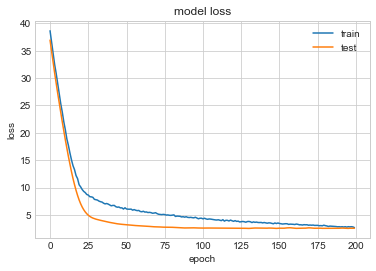

In [24]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

## <a class="anchor" id="3.4-bullet">3.4 Random Forrest</a>


In [29]:
rf = RandomForestRegressor()
rf.fit(X_train_sc, y_train)
rf.score(X_test_sc, y_test)


0.3854051521855573

In [22]:
paramz = {
    'max_features': [.4, .5, .7],
    'n_estimators': [90, 100, 150]
    
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=paramz)
gs.fit(X_train_sc, y_train)
gs.score(X_test_sc, y_test)

0.4542280368346285

In [24]:
### writing out a pickled version of my model (naming it "titanic2_rf.pkl")
with open('./pickles/rf_model.pkl', 'wb') as file:  
    pickle.dump(gs, file)

In [28]:
with open('./pickles/rf_scaler.pkl', 'wb') as file:  
    pickle.dump(ss, file)

In [29]:
cols_include

['caption',
 'definition',
 'duration',
 'licensedContent',
 'regionRestriction',
 'contentRating',
 'year',
 'month_day',
 'week_day',
 'week',
 'description_sentiment',
 'description_wordcount',
 'tags_wordcount',
 'title_featuring',
 'intitle_a',
 'intitle_d',
 'intitle_f',
 'intitle_g',
 'intitle_i',
 'intitle_k',
 'intitle_l',
 'intitle_p',
 'intitle_v',
 'intitle_x',
 'intitle_y',
 'title_length',
 'is_weekend',
 'is_friday']

In [30]:
preds = gs.predict(X_test_sc)

In [37]:
((preds - y_test)**2).mean()

1.3579505449507934

## <a class="anchor" id="3.4-bullet">3.4 Bagger</a>


In [144]:
br = BaggingRegressor(GradientBoostingRegressor())

br.fit(X_train_sc, y_train)
br.score(X_test_sc, y_test)

0.4282070834923405

# <a class="anchor" id="4.0-bullet">4. Comparison</a>


In [145]:
df_big = df_main[df_main.viewCount > 800000000]
df_big_ss = ss.transform(df_big.loc[:, cols_include])

df_big['GradientBoost'] = 10**gb.predict(df_big_ss)
df_big['NeuralNet'] = 10**nn.predict(df_big_ss)
df_big['RandomForest'] = 10**rf.predict(df_big_ss)
df_big['Bagger'] = 10**br.predict(df_big_ss)
df_big['GSForest'] = 10**gs.predict(df_big_ss)
#df_big.viewCount = df_big.viewCount.map(lambda x: '{:.6g}'.format(x))
df_big.loc[:, ['title', 'viewCount', 'RandomForest', 'GSForest','GradientBoost', 'NeuralNet', 'Bagger',]].sort_values(by='viewCount', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,title,viewCount,RandomForest,GSForest,GradientBoost,NeuralNet,Bagger
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,2.496158e+09,8.597120e+08,1.425859e+08,7.625878e+06,8.712146e+07
4268,Ed Sheeran - Shape of You [Official Video],3827104659,8.655010e+07,2.864850e+08,1.978355e+07,5.550064e+06,2.239065e+07
7190,Wiz Khalifa - See You Again ft. Charlie Puth [...,3788737518,9.715079e+08,4.040290e+08,2.394033e+08,4.024046e+07,1.059816e+08
5540,Mark Ronson - Uptown Funk ft. Bruno Mars,3256917992,1.316679e+09,6.812185e+08,6.611473e+07,1.160306e+07,5.597575e+07
3634,PSY - GANGNAM STYLE(강남스타일) M/V,3218413082,3.845512e+08,6.396386e+08,1.665459e+07,1.544227e+06,1.048376e+07
569,Justin Bieber - Sorry (PURPOSE : The Movement),3014897224,2.108729e+06,7.706637e+06,9.482050e+07,4.149746e+06,3.066570e+07
7417,Maroon 5 - Sugar,2756205542,3.822505e+06,1.798069e+06,2.994625e+06,1.691955e+06,4.166016e+06
7514,Taylor Swift - Shake It Off,2650920924,2.180778e+09,6.581992e+08,3.089242e+07,7.743163e+06,2.423377e+07
5506,Katy Perry - Roar (Official),2638406673,1.170080e+09,4.316583e+08,5.894900e+07,1.509130e+07,5.335661e+07
627,Enrique Iglesias - Bailando (Español) ft. Desc...,2582945265,5.121747e+07,3.042361e+07,1.813790e+07,4.943104e+06,1.430484e+07


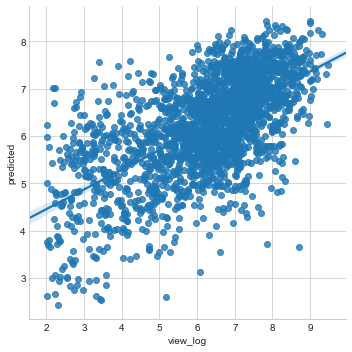

In [65]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = rf.predict(X_test_sc)
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_log 
sns.lmplot('view_log', 'predicted', data=df_residuals)

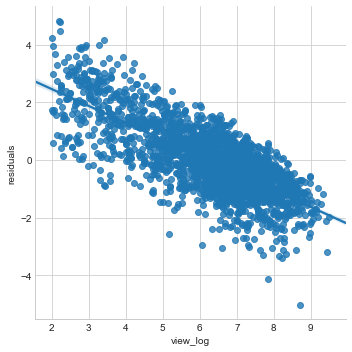

In [67]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = rf.predict(X_test_sc)
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_log 
sns.lmplot('view_log', 'residuals', data=df_residuals)

In [41]:
# outliers = list(df_residuals.sort_values(by='residuals').iloc[:10, :].index)
temp = df_main
outliers_df = df_residuals.sort_values(by='residuals').iloc[:10, :].loc[:, ['predicted', 'residuals']]
temp.join(outliers_df, how='right').loc[:, ['title', 'view_log', 'predicted', 'lv_ratio']]

,title,view_log,predicted,lv_ratio
4696,XXXTENTACION - SAD!,8.694612,3.662014,0.774674
4460,I'm Yours(ukulele),7.842553,3.716056,0.729217
4397,Sean Paul Y Sasha - Im Still In Love With You.mp4,8.233972,4.831262,0.713166
5530,Chance the Rapper ft. 2 Chainz & Lil Wayne - N...,8.132406,4.817742,0.724569
1307,Pomme de reinette et pomme d'api,7.695701,4.381866,0.610474
7567,Eminem - Stan (Long Version) ft. Dido,8.325714,5.060115,0.730691
7417,Maroon 5 - Sugar,9.440312,6.252751,0.737173
439,Chuck Berry - Johnny B. Goode,7.626958,4.511548,0.710110
1557,"Atif Aslam, Tajdar-e-Haram, Coke Studio Season...",8.257826,5.143164,0.739046
7437,Tom Odell - Another Love (Zwette Edit),8.586417,5.474062,0.711195


# <a class="anchor" id="5.0-bullet">5. Back Testing and Interpretation</a>

## <a class="anchor" id="5.1-bullet">5.1 Indentifying Indicators</a>

In [39]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(exclude_ratios=True, additional_cols_include=['year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount'])
gb_full = GradientBoostingRegressor(random_state=42)
gb_full.fit(X_train_sc, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [40]:
df_importance = pd.DataFrame(gb_full.feature_importances_, 
                             index=cols_include, columns=['importance'])

lin_mod = Ridge()
lin_mod.fit(X_train_sc, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [57]:
df_importance['linear_coeffs'] = lin_mod.coef_

df_importance.sort_values(by='importance', ascending=False).head(15)

,importance,linear_coeffs
duration,0.129900,-0.034307
year,0.123238,-0.603535
year_day,0.083176,-0.776984
description_wordcount,0.070063,0.137128
description_sentiment,0.059647,0.032836
tags_wordcount,0.054818,0.141812
title_length,0.045951,-0.229150
licensedContent,0.043784,0.439218
caption,0.040271,0.248707
intitle_a,0.035965,0.079651


In [54]:
feature_dict = {}
for col in list(df_importance.sort_values(by='importance', ascending=False).head(15).index)+['title_featuring']:
    feature_dict[col] = df_main[df_main[col]>df_main[col].mean()].view_log.mean() / df_main[df_main[col]<df_main[col].mean()].view_log.mean()

In [64]:
pd.DataFrame(feature_dict, index=range(len(feature_dict.keys()))).T.iloc[:, 0].sort_values(ascending=False)

licensedContent          1.184131
caption                  1.178059
regionRestriction        1.170682
title_featuring          1.141444
tags_wordcount           1.112119
description_wordcount    1.092061
description_sentiment    1.073829
tags_sentiment           1.062192
intitle_a                1.025141
title_sentiment          1.017641
title_wordcount          1.014168
title_length             1.003008
intitle_p                0.966667
year_day                 0.961124
year                     0.923658
duration                 0.873423
Name: 0, dtype: float64

## <a class="anchor" id="5.12-bullet">5.2 New Pulls</a>

In [42]:
df_new = pd.read_csv('./data/engineered_data/data_engineered_round2_10.14_1545.csv')

In [43]:
df_new_data = df_new[df_new['view_class']>1]

target_new = df_new_data.view_log

df_new_data_sc = df_new_data.loc[:, cols_include]

df_new_data_sc = ss.transform(df_new_data_sc)

preds_new = rf.predict(df_new_data_sc)

In [45]:
rf.score(df_new_data_sc, target_new)

0.4879212467098322

In [46]:
df_new_predicted = df_new_data

df_new_predicted['predicted'] = preds_new

df_new_predicted = df_new_predicted[pd.to_datetime(df_new_predicted.publishedAt)>datetime.datetime(2018, 10, 2)]

df_new_predicted.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(427, 71)

In [49]:
df_new_predicted.loc[:, ['vidId','title', 'view_log', 'predicted', 'licensedContent']].sort_values(by='predicted', ascending=False)

,vidId,title,view_log,predicted,licensedContent
325,yoxb1FLISaA,BADA$$ B. - Me Gusta (Prod. Razihel),5.756380,5.987943,0
1965,a3OIkfphUas,F.Lackó-Konditerem (Official Music Video),3.720738,5.945407,0
753,oxOieolBxPc,"Shinedown ""Heroes"" (Drum Cover)~Brooke C~",4.366666,5.918928,0
328,44IMtZWfyJU,"B La B Feat. Lil Baby ""Sunday Morning"" (WSHH E...",5.725669,5.910320,0
28,GW_gsNVM498,Genie in a Bottle - Christina Aguilera ('60s S...,5.409544,5.709371,0
2121,PYmd1blKNsc,[MASHUP] Girls' Generation-Oh!GG & BoA - Lil' ...,2.340444,5.650826,0
6526,xPQYJrP85Lg,[KPOP REACTION] STATION X 0 -- 슬기(SEULGI)X신비(여...,3.720655,5.644035,0
3894,sueklH19KZ8,OLDELAF L'Amour à l'Hôtel Ibis [Clip officiel],4.608248,5.549975,0
6239,E97v5KGfabE,J$R ไลฟ์สุดมันส์ | รายการ JOOX Weekly Update [...,2.788875,5.514241,0
4558,yrVzITgFNyk,Protocat - These Chords (feat. N. Hollow) [Dru...,3.297542,5.483253,0


In [48]:
df_new_predicted[abs(df_new_predicted.predicted - df_new_predicted.view_log)>2].loc[:, ['vidId','title', 'view_log', 'predicted']].sort_values(by='predicted', ascending=False)

,vidId,title,view_log,predicted
1965,a3OIkfphUas,F.Lackó-Konditerem (Official Music Video),3.720738,5.945407
2121,PYmd1blKNsc,[MASHUP] Girls' Generation-Oh!GG & BoA - Lil' ...,2.340444,5.650826
6239,E97v5KGfabE,J$R ไลฟ์สุดมันส์ | รายการ JOOX Weekly Update [...,2.788875,5.514241
4558,yrVzITgFNyk,Protocat - These Chords (feat. N. Hollow) [Dru...,3.297542,5.483253
433,PwerdTqlR74,"Concert LIVE Anthony B, Jah Mason, Turbulence,...",3.042576,5.301521
6122,pMNetv_924s,R.MOS - HABLA HABLA (PROD. TACOS),2.537819,5.262290
755,toava4gCTgU,C Life - Marilyn Monroe (Official Video),2.187521,5.243683
2822,WMWikFah6aM,H BLAK AUGUST - #Happy birthay (clip official ...,2.990783,5.243111
6102,x8EoF9nuXek,r - Mixtape « Porte Tes Couilles »,2.086360,5.100330
6082,N0-E57zDm0g,Calu Ke - SNOW ❄ (Official Video) (Gunna Type ...,3.005181,5.093687
